Tested in Colab: https://colab.research.google.com/drive/12Qnq7YG-WapM8zquCodNONu3wQX4oefX?usp=sharing

<h1>Explaining Distilbert for Sequence Classification</h1>

<h1>Attempt 2: Visualize Word Embeddings and their Shap value</h1>

In [ ]:
!pip install shap
!pip install transformers[torch]
!pip install nlp
!pip install torch
!pip install scipy
!pip install adjusttext

In [3]:
import shap
import transformers
import nlp
import torch
import numpy as np
import scipy as sp
import string
import nltk
import re

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import sys
np.set_printoptions(threshold=sys.maxsize)
from adjustText import adjust_text

from transformers import DistilBertTokenizerFast
from transformers import AutoModelForSequenceClassification

<h1>Loading the Model, the Tokenizer and creating Shap values for the IMDB trainingset</h1>

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained("textattack/distilbert-base-uncased-imdb", num_labels=2, output_attentions=True).cuda()

# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=500, truncation=True) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

# explain the model's predictions on IMDB reviews, taking just the first 100 reviews
imdb_train = nlp.load_dataset("imdb")["train"]
shap_values = explainer(imdb_train[:100], fixed_context=1)

<h1>Storing Words and respected Shap values in a dictionary</h1>

In [5]:
data_flat = [item for sublist in shap_values.feature_names for item in sublist]
shap_values_flat = list(np.concatenate(shap_values.values).ravel())

sum_dict = {}

for key, val in zip(data_flat, shap_values_flat): 
    sum_dict[key] = sum_dict.get(key, 0) + val 

count_dict = dict((x, data_flat.count(x)) for x in set(data_flat))
mean_dict = dict((k, float(sum_dict[k]) / count_dict[k]) for k in sum_dict)

In [ ]:
mean_dict # dictionary containing all words and the respected shap values

In [16]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
def loadLines_shap(words, values):
    """
    This function filters words and removes unimportant tags and chars
    """
    lines_words = np.array([])
    lines_values = np.array([])
    wordcount = 0
    for word, value in zip(words, values):
        if word not in stopwords:
            w = "".join([c for c in word if c not in string.punctuation])
            if (len(w) > 2) and (np.abs(value) >= 0.1):
              lines_words = np.append(lines_words, w.lower())
              lines_values = np.append(lines_values, value)
        

    print("Done. ", len(lines_words)," lines loaded!")
    wordcount = len(lines_words)
    print("wordcount: ", wordcount)
    return lines_words, lines_values, wordcount

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h1>Filtering and Cleaning Words</h1>

In [17]:
words = list(mean_dict.keys())
values = list(mean_dict.values())

bertwords, bertvalues, wordcount = loadLines_shap(words, values)

norm_min = min(bertvalues)  # used for normalizing color in the plot
norm_max = max(bertvalues)  # used for normalizing color in the plot
wordcount = len(bertwords)


print("min: ", norm_min)
print("max ", norm_max)
print("wordcount: ", wordcount)

Done.  470  lines loaded!
wordcount:  470
min:  -3.154264503264204
max  2.0223761749171896
wordcount:  470


<h1>Creating the embeddings for the words</h1>

In [18]:
# Tokenize Words
tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=10, truncation=True) for v in bertwords]).cuda()
# create embeddings
bert_word_embs_to_use = model(tv)[0].detach().cpu().numpy()

<h1>Using t-SNE to downproject the embeddings into 2-D space</h1>

In [ ]:
# Run t-SNE on the BERT vocabulary embeddings we selected:
mytsne_words = TSNE(n_components=2,early_exaggeration=12,verbose=2,metric='cosine',init='pca',n_iter=2000)
bert_word_embs_to_use_tsne = mytsne_words.fit_transform(bert_word_embs_to_use)

<h1>Plotting the downprojected words and coloring them according to their mean Shap value</h1>

now running adjust_text
done adjust text, num iterations:  50


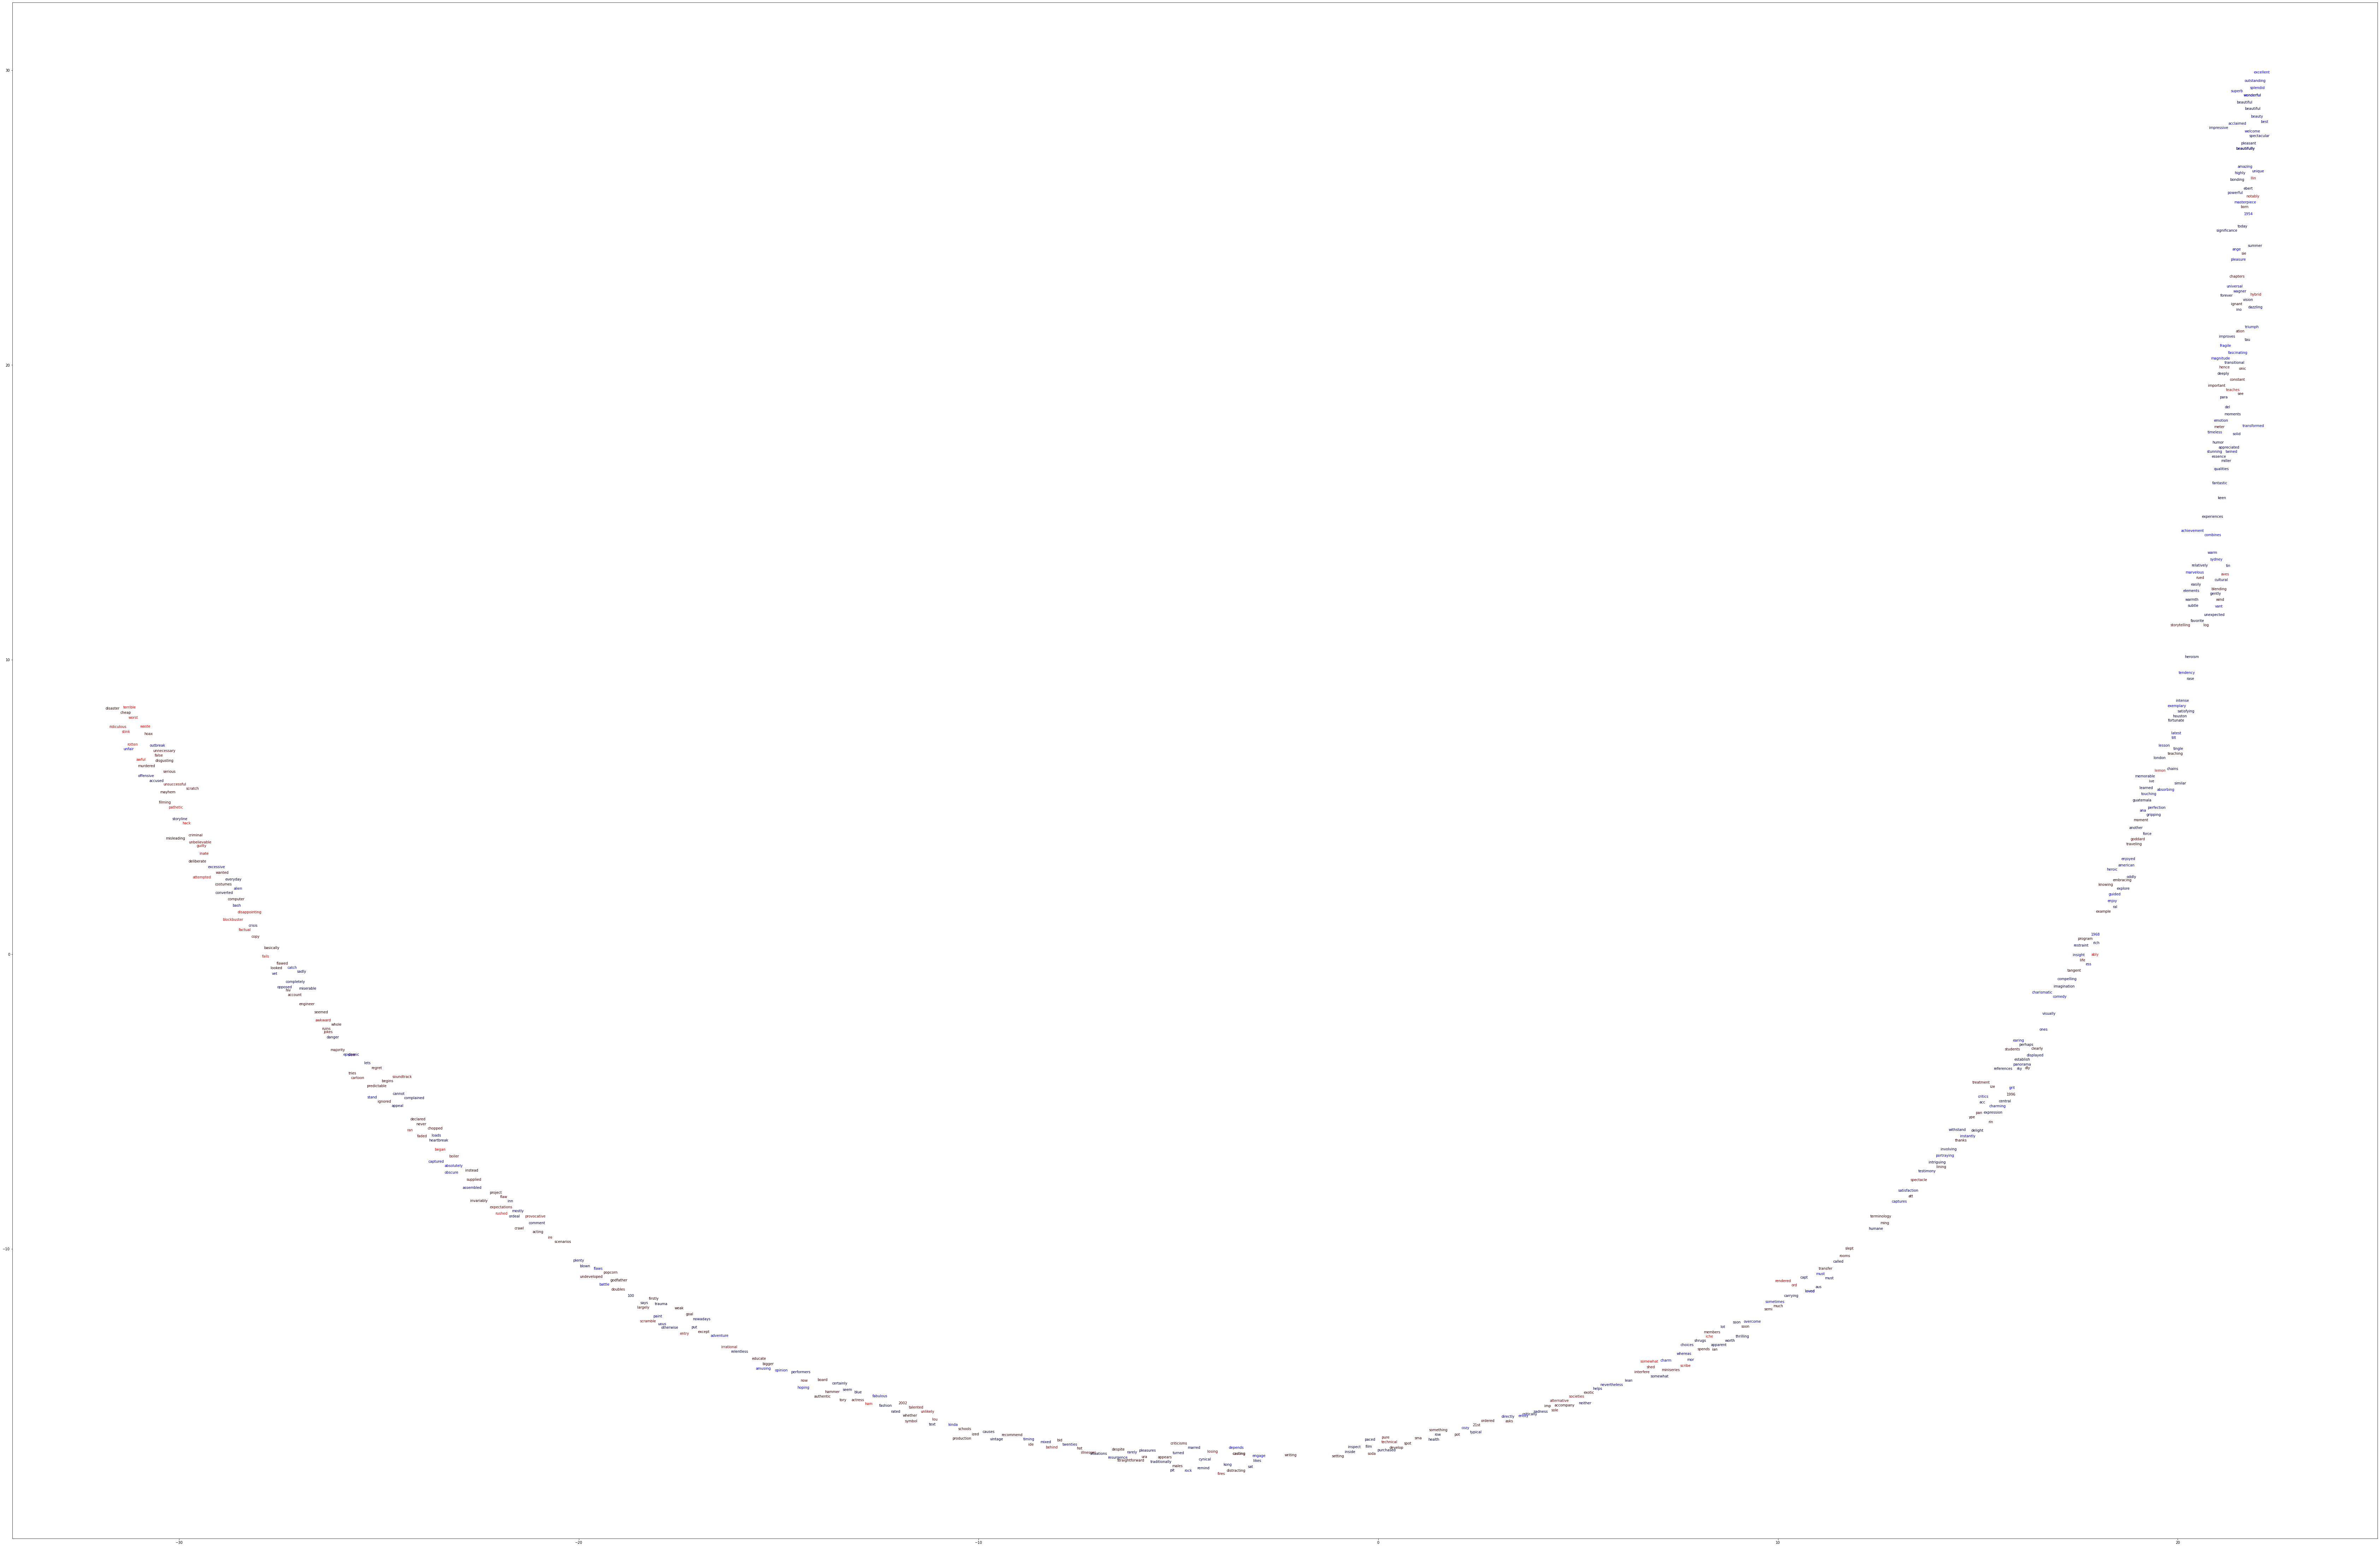

In [21]:
# Plot the transformed BERT vocabulary embeddings:
bert_words_to_plot = bertwords
plt.rcParams['figure.figsize'] = [120, 80]
fig = plt.figure()
alltexts = list()
for i, txt in enumerate(bert_words_to_plot):
    plt.scatter(bert_word_embs_to_use_tsne[i,0], bert_word_embs_to_use_tsne[i,1], s=0)
    shap_v = bertvalues[i]
    if shap_v <= 0:
        c_map = (min(abs(shap_v/norm_min)*5, 1.),0.,0.)
    else:
        c_map = (0.,0., min(abs(shap_v/norm_max)*5, 1.))
    currtext = plt.text(bert_word_embs_to_use_tsne[i,0], bert_word_embs_to_use_tsne[i,1], txt, family='sans-serif', color=c_map)
    alltexts.append(currtext)
    

# Save the plot before adjusting.
plt.savefig('viz-bert-voc-tsne10k-viz4k-noadj.pdf', format='pdf')
print('now running adjust_text')
# Using autoalign often works better in my experience, but it can be very slow for this case, so it's false by default below:

numiters = adjust_text(alltexts, autoalign=False, lim=50) # using adjusttext to try minimzing overlaps when plotting
print('done adjust text, num iterations: ', numiters)
plt.savefig('viz-bert-voc-tsne10k-viz4k-adj50.pdf', format='pdf')

plt.show()